In [239]:
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import pandas as pd
import os
from astLib import astSED
import astropy.io.fits as fits
from carf import * # custom module for functions relating to the project
import matplotlib.path as mpath
import seaborn as sns
from scipy.stats import gaussian_kde
import scipy as sp

# So that we can change the helper functions without reloading the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [240]:
# We need to ensure we are reading in our final dataframe we will be doing our analysis on. This dataframe should contain
zfourge_full = pd.read_csv('datasets/full_zfourge_decomposed/zfourge_full.csv')

C:\Users\Titan\AppData\Local\Temp\ipykernel_4624\2707125321.py:2: DtypeWarning: Columns (156) have mixed types. Specify dtype option on import or set low_memory=False.
  zfourge_full = pd.read_csv('datasets/full_zfourge_decomposed/zfourge_full.csv')


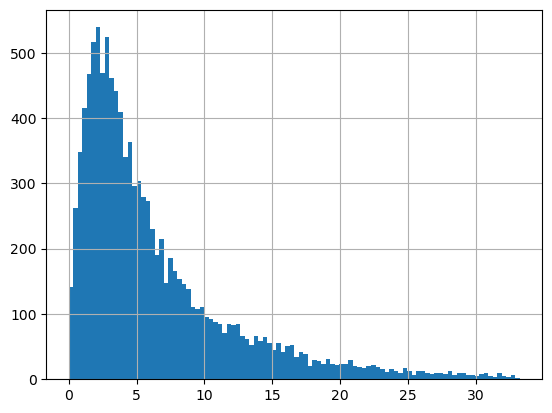

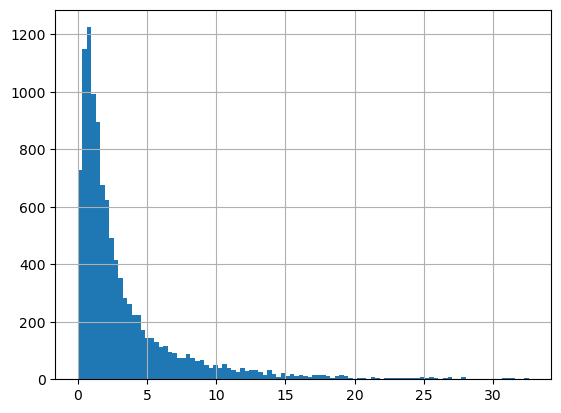

<Axes: >

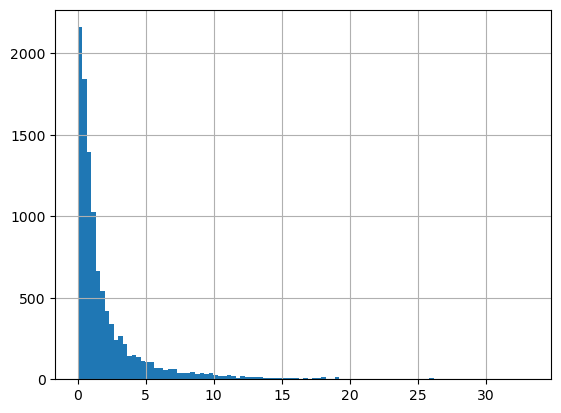

In [241]:
# Loook for the uvj errors
# zfourge_full['eU']
# zfourge_full['eV']
# zfourge_full['eJ']
# This is good cause it's not yet in magnitude, it's a flux value
((zfourge_full['eU']/zfourge_full['U'])*100).hist(bins=100)
plt.show()

((zfourge_full['eV']/zfourge_full['V'])*100).hist(bins=100)
plt.show()

((zfourge_full['eJ']/zfourge_full['J'])*100).hist(bins=100)


In [242]:
# create a flux to mag function
def flux_to_mag(flux):
    return -2.5*np.log10(flux) + 25

# create a flux to mag error function
def flux_to_mag_error(flux, error): # <- single mag error
    return np.abs((-2.5/np.log(10))*(error/flux))

def ab_mag_to_flux(mag):
    return 10**((25-mag)/2.5)


In [243]:
# flux to magnitude
# Calculate the magnitude
zfourge_full['Umag'] = flux_to_mag(zfourge_full['U'])
zfourge_full['Vmag'] = flux_to_mag(zfourge_full['V'])
zfourge_full['Jmag'] = flux_to_mag(zfourge_full['J'])

# Calculate the error in the magnitude
# zfourge_full['eUmag'] = flux_to_mag_error(zfourge_full['U'], zfourge_full['eU'])
# zfourge_full['eVmag'] = flux_to_mag_error(zfourge_full['V'],zfourge_full['eV'])
# zfourge_full['eJmag'] = flux_to_mag_error(zfourge_full['J'], zfourge_full['eJ'])

# Instead just convert the error directly into magnitude
zfourge_full['eUmag'] = flux_to_mag_error(zfourge_full['U'],zfourge_full['eU'])
zfourge_full['eVmag'] = flux_to_mag_error(zfourge_full['V'],zfourge_full['eV'])
zfourge_full['eJmag'] = flux_to_mag_error(zfourge_full['J'], zfourge_full['eJ'])


# For error calculation we can convert the magnitudes to microjanskys and then perform the calculations. -> or we can just 
# Convert the errors from magnitudes to fluxes and then calculate the error in the fluxes. This is the same as the above
# mag

# convert ab mag to rest frame flux
zfourge_full['fU_Full'] = ab_mag_to_flux(zfourge_full['U_full'])
zfourge_full['fV_Full'] = ab_mag_to_flux(zfourge_full['V_full'])
zfourge_full['fJ_Full'] = ab_mag_to_flux(zfourge_full['J_full'])

# convert ab mag to rest frame flux
zfourge_full['fU_decomposed'] = ab_mag_to_flux(zfourge_full['U_decomposed'])
zfourge_full['fV_decomposed'] = ab_mag_to_flux(zfourge_full['V_decomposed'])
zfourge_full['fJ_decomposed'] = ab_mag_to_flux(zfourge_full['J_decomposed'])


# all we will need to do is rerun the CIGALE code and than use the code below to generate the errors.
# Instead just convert the error directly into magnitude
zfourge_full['eUmag_full'] = flux_to_mag_error(zfourge_full['fU_full'],zfourge_full['eU'])
zfourge_full['eVmag_full'] = flux_to_mag_error(zfourge_full['fV_full'],zfourge_full['eV'])
zfourge_full['eJmag_full'] = flux_to_mag_error(zfourge_full['fJ_full'], zfourge_full['eJ'])

zfourge_full['eUmag_decomposed'] = flux_to_mag_error(zfourge_full['fU_decomposed'],zfourge_full['eU'])
zfourge_full['eVmag_decomposed'] = flux_to_mag_error(zfourge_full['fV_decomposed'],zfourge_full['eV'])
zfourge_full['eJmag_decomposed'] = flux_to_mag_error(zfourge_full['fJ_decomposed'], zfourge_full['eJ'])

# Create the colours
zfourge_full['UV_full'] = zfourge_full['U_full'] - zfourge_full['V_full']
zfourge_full['VJ_full'] = zfourge_full['V_full'] - zfourge_full['J_full']

zfourge_full['UV_decomposed'] = zfourge_full['Umag_decomposed'] - zfourge_full['Vmag_decomposed']
zfourge_full['VJ_decomposed'] = zfourge_full['Vmag_decomposed'] - zfourge_full['Jmag_decomposed']


# Create the errors in the colours
zfourge_full['eUV_full'] = np.sqrt(zfourge_full['eUmag_full']**2 + zfourge_full['eVmag_full']**2)
zfourge_full['eVJ_full'] = np.sqrt(zfourge_full['eVmag_full']**2 + zfourge_full['eJmag_full']**2)

zfourge_full['eUV_decomposed'] = np.sqrt(zfourge_full['eUmag_decomposed']**2 + zfourge_full['eVmag_decomposed']**2)
zfourge_full['eVJ_decomposed'] = np.sqrt(zfourge_full['eVmag_decomposed']**2 + zfourge_full['eJmag_decomposed']**2)


# This is good but instead I'll need to provide the flux values from astSED, currently I only was outputting the actual colours

In [244]:
# # Calculate the UV colours
zfourge_full['UV_cols'] = zfourge_full['Umag'] - zfourge_full['Vmag']

# # Calculate the VJ colours
zfourge_full['VJ_cols'] = zfourge_full['Vmag'] - zfourge_full['Jmag']


# Calculate the error in the colours
zfourge_full['eUV_cols'] = np.sqrt(zfourge_full['eUmag']**2 + zfourge_full['eVmag']**2)
zfourge_full['eVJ_cols'] = np.sqrt(zfourge_full['eVmag']**2 + zfourge_full['eJmag']**2)



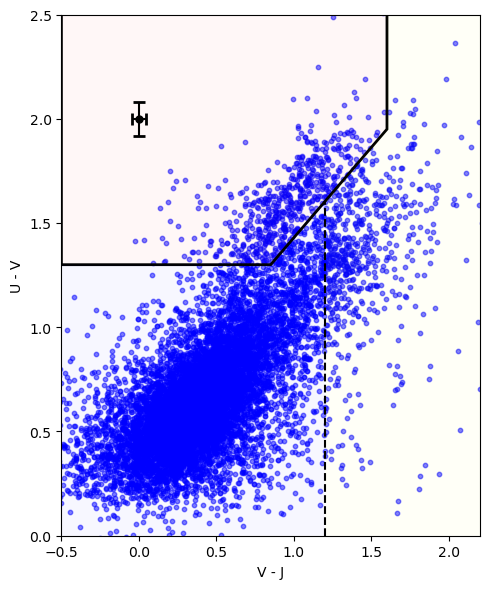

In [245]:
# Plot a test UVJ diagram
# Maybe just plot an all redshift UVJ diagram 
fig, axs = plt.subplots(1, 1, figsize=(5, 6), sharex=True, sharey=True)


vj = zfourge_full['VJ_cols']
uv = zfourge_full['UV_cols']

# Plot the UVJ diagram
axs.scatter(vj, uv, c='blue', s=10, alpha=0.5, marker='o')

# choose a point to plot an average error bar
# get the average error
avg_error_UV = np.mean(zfourge_full['eUV_cols'])
avg_error_VJ = np.mean(zfourge_full['eVJ_cols'])

# Plot the error bar
axs.errorbar(0, 2, xerr=avg_error_VJ, yerr=avg_error_UV, fmt='o', color='black', markersize=5, capsize=4, capthick=2)

# axs.errorbar(1.2, 1.6, xerr=0.1, yerr=0.1, fmt='o', color='black', markersize=10, capsize=5, capthick=2)

# Define paths for selections
path_quiescent = [[-0.5, 1.3], [0.85, 1.3], [1.6, 1.95], [1.6, 2.5], [-0.5, 2.5]]
path_sf = [[-0.5, 0.0], [-0.5, 1.3], [0.85, 1.3], [1.2, 1.60333], [1.2, 0.0]]
path_sfd = [[1.2, 0.0], [1.2, 1.60333], [1.6, 1.95], [1.6, 2.5], [2.2, 2.5], [2.2, 0.0]]

# We will obtain the Star-forming, Quiescent, and Dusty Fractions for this particular alpha value     
# Obtain the number of galaxies with sf region dictated by the sf path
# Create Path objects from your path coordinates (do this once, outside the loop)
path_quiescent_obj = mpath.Path(path_quiescent)
path_sf_obj = mpath.Path(path_sf)
path_sfd_obj = mpath.Path(path_sfd)

# Add patches for selections
axs.add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
axs.add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
axs.add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))

# Add vertical line
axs.axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)

# Add axis labels
axs.set_xlabel("V - J")
axs.set_ylabel("U - V")


# Ensure limits
axs.set_xlim(-0.5, 2.2)
axs.set_ylim(0, 2.5)
    # Make the subplots closer together
# plt.subplots_adjust(wspace=0.05, hspace=0.3)


plt.tight_layout()





plt.show()